In [16]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def plotter(dat,label,fmt,fillstyle='full'):
    if 's=7' in label:
        plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,color='C0',label=label,capsize=3,fillstyle=fillstyle)
    else:
        plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fmt=fmt,label=label,capsize=3,fillstyle=fillstyle)

In [25]:
#######
# s=1 #
#######

lscales = {}

######
# v' # 
######
lscales['v'] = {}

# TRANSVERSE
lscales['v']['ly_L99'] = {# Ly/L99
0.2:[0.260402269172,0.0301586301326],
0.4:[0.210549980468,0.0134039531158],
0.8:[0.148598198022,0.00912257486773],
1.2:[0.129131147199,0.0105790450289],
1.6:[0.120268726539,0.0151090035874],
2.0:[0.0980075020492,0.00857010046639],
}
lscales['v']['ly_dtheta'] = {

}

# STREAMWISE 
lscales['v']['lx_L99'] = { # lx/L99
0.2: [0.521318569327, 0.0395020583657],
0.4: [0.451137946375, 0.0512538138099],
0.8: [0.267320052369, 0.011683596225],
1.2: [0.234510200214, 0.0258215189548],
1.6: [0.198769543519, 0.0220920650474],
2.0: [0.184273076222, 0.0221718306893],
}
lscales['v']['lx_dtheta'] = { # lx/dtheta
0.2: [3.85810942041, 0.275795478932],
0.4: [3.48921576101, 0.399650767425],
0.8: [2.0915338895, 0.112644468128],
1.2: [1.94881375641, 0.227162021316],
1.6: [1.76440051639, 0.207046521544],
2.0: [1.81101333804, 0.219987176759],
}
lscales['v']['lx_ly'] = {
0.2: [1.75989443707, 0.114665522974],
0.4: [1.91583330042, 0.162291378435],
0.8: [1.76234636862, 0.0881001617297],
1.2: [1.80683930355, 0.167975144252],
1.6: [1.72959575559, 0.157338293607],
2.0: [1.7774207714, 0.186547036638],
}
lscales['v']['ly_L99_top'] = {
0.2:[0.342507086441,0.038921615535],
0.4:[0.310494254597,0.0481446388096],
0.8:[0.197644817385,0.0168248220528],
1.2:[0.163308941552,0.0138117715087],
1.6:[0.126537550943,0.0104188803283],
2.0:[0.129536323403,0.00885711396447],
}
lscales['v']['ly_L99_bot'] = {
0.2:[0.356039659555,0.0401063381978],
0.4:[0.322873341816,0.0484560913252],
0.8:[0.193064300104,0.0176429391621],
1.2:[0.152346387392,0.0129092669104],
1.6:[0.136510005062,0.0099917058656],
2.0:[0.100839501385,0.00749989522654],
}

# SPANWISE 
lscales['v']['lz_L99'] = { # lx/L99
0.2: [0.36694898397, 0.0212137248113],
0.4: [0.280511619521, 0.019738093756],
0.8: [0.167833063906, 0.00817394887306],
1.2: [0.138850963294, 0.00512699300734],
1.6: [0.128121061604, 0.0117000329304],
2.0: [0.111059092678, 0.00999286564289],
}
lscales['v']['lz_dtheta'] = { # lx/dtheta
0.2: [2.71351264664, 0.159902684853],
0.4: [2.18583068029, 0.134575776467],
0.8: [1.31606242759, 0.0694888874129],
1.2: [1.15164530306, 0.0227876784285],
1.6: [1.13687557917, 0.10760334888],
2.0: [1.09109071501, 0.0946917366243],
}
lscales['v']['lz_ly'] = {
0.2: [1.22163665548, 0.110775997749],
0.4: [1.24418935067, 0.108192146985],
0.8: [1.08811839932, 0.0950757164193],
1.2: [1.08788475146, 0.0610885789127],
1.6: [1.11658725844, 0.0971401343019],
2.0: [1.07458790835, 0.110625362821],
}

######
# U' # 
######

# Are these updated?

lscales['u'] = {}
lscales['u']['ly_L99'] = {
0.2: [0.217184044808, 0.0404446869392],
0.4: [0.205724503316, 0.0319463901088],
0.8: [0.21244653152, 0.0427106550508],
1.2: [0.196861430653, 0.0222357155528],
1.6:[0.145619671713,0.0181099336312],
2.0:[0.156100737512,0.0396032589747],
}
lscales['u']['lx_ly'] = {
0.2:[18.203674798,15.7265307967],
0.4:[17.3955000386,20.3094042283],
0.8:[11.5527278867,8.09124104877],
1.2:[11.3664208408,6.50076167438],
1.6:[14.7259020302,9.71009800896],
2.0:[8.89141190023,8.97832095345],
}
lscales['u']['lz_ly'] = {
0.2:[9.09906452741,7.85547065516],
0.4:[8.70136587556,10.1294552241],
0.8:[5.66530097761,4.50865826429],
1.2:[1.33821335031,0.351678346144],
1.6:[1.66770514267,0.45786737168],
2.0:[2.0366430086,1.62634301547],
}

######
# P' # 
######

# are these updated?

lscales['p'] = {}
lscales['p']['ly_L99'] = {
0.2:[0.845815817682,0.00796988668202],
0.4:[0.698487404408,0.11072240257],
0.8:[0.601662039403,0.0446973253622],
1.2:[0.345029305599,0.0902128854104],
1.6:[0.246203610228,0.0977139845744],
2.0:[0.192412810687,0.0600864472128],
}
lscales['p']['lx_ly'] = { # lx/ly
0.2:[3.71524522818,1.966748337],
0.4:[2.9012346977,2.58601737632],
0.8:[8.4810138181,1.94211539173],
1.2:[11.2616899418,2.70950641842],
1.6:[18.2764259696,4.32662035681],
2.0:[21.2858453278,4.72778825461],
}
lscales['p']['lz_ly'] = { # lz/ly
0.2:[1.85762261409,0.983374168502],
0.4:[1.45085507444,1.2935016056],
0.8:[4.23222451493,0.967562444659],
1.2:[5.5945184558,1.35278446942],
1.6:[9.00193294673,2.14712760705],
2.0:[10.400309381,2.31651646411],
}

########
# u'v' # 
########
lscales['upvp'] = {}
lscales['upvp']['ly_L99'] = {
0.2: [0.563282174987,0.0644702415358],

0.8: [0.401377428825,0.050038943189],
1.2: [0.392574025529,0.0304210237768],
1.6: [0.352114201842,0.0276489879829],
2.0: [0.316171925523,0.0267301132045],

}
########
# u'v" # 
########
lscales['upvpp'] = {}
lscales['upvpp']['ly_L99'] = {
0.2: [0.563282174987,0.0644702415358],
    
0.8: [0.401377428825,0.050038943189],
1.2: [0.392574025529,0.0304210237768],
1.6: [0.352114201842,0.0276489879829],
2.0: [0.316171925523,0.0267301132045],
}


In [3]:
#######
# s=7 #
#######
lscales_s7 = {}

######
# V' # 
######
lscales_s7['v'] = {}
lscales_s7['v']['ly_L99'] = {
0.2:[0.330201801034,0.00637322462226],
0.8:[0.254559849028,0.0114950356107],
2.0:[0.17024371122,0.0516906200322],
}
######
# P' # 
######
lscales_s7['p'] = {}
lscales_s7['p']['ly_L99'] = {
0.2:[0.699530570789,0.0401965350737],
0.8:[0.470592519587,0.0600051817717],
2.0:[0.237014985854,0.0295487843553],
}
        

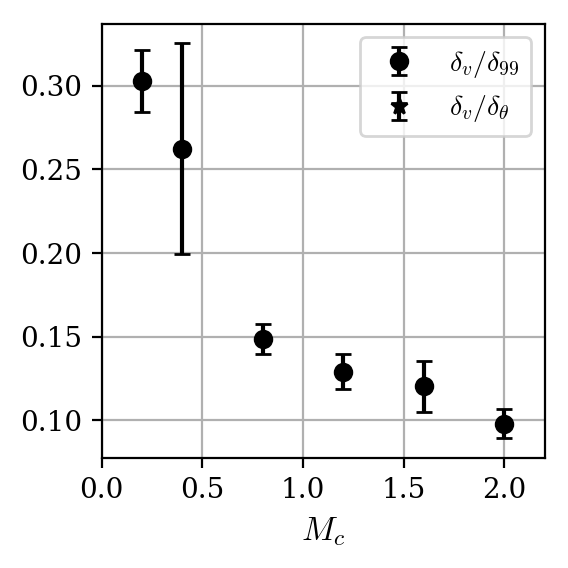

In [18]:

fig = plt.figure(figsize=(3,3),dpi=200)
plotter(lscales['v']['ly_L99'],r"$\delta_{v}/\delta_{99}$",'ko')
plotter(lscales['v']['ly_dtheta'],r"$\delta_{v}/\delta_{\theta}$",'k*')
# plotter(lscales_s7['v']['ly_L99'],r'$\delta_y(v^\prime), s=7$','o')
# plotter(lscales['p']['ly_L99'],r'$\delta_y(p^\prime), s=1$','ks')
# plotter(lscales_s7['p']['ly_L99'],r'$\delta_y(p^\prime), s=7$','s')

plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$\delta_y$')
plt.legend(fontsize=10)
plt.xlim([0,2.2])
# plt.ylim([0.5,2.2])
plt.tight_layout()


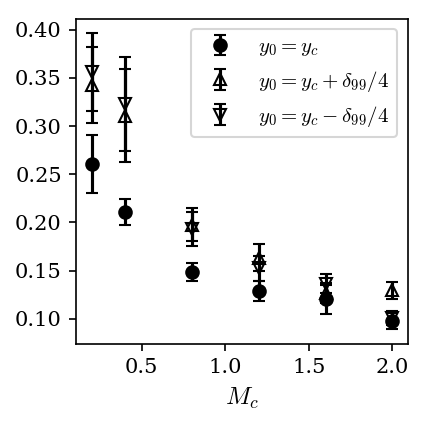

In [26]:
    
fig = plt.figure(figsize=(3,3),dpi=150)
plotter(lscales['v']['ly_L99'],r'$y_0=y_c$','ko')
plotter(lscales['v']['ly_L99_top'],r'$y_0=y_c+\delta_{99}/4$','k^',fillstyle='none')
plotter(lscales['v']['ly_L99_bot'],r'$y_0=y_c-\delta_{99}/4$','kv',fillstyle='none')

# plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$\delta_y$')

plt.tight_layout()
plt.legend(fontsize=10)

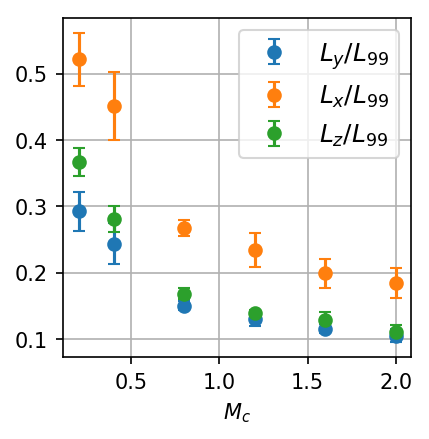

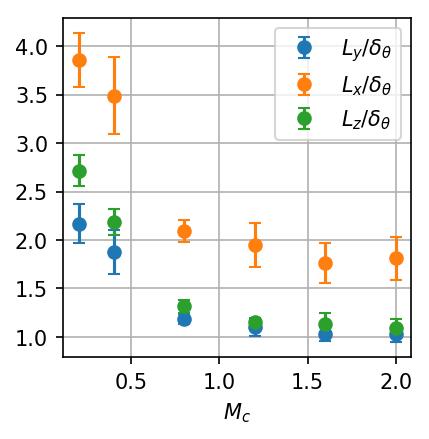

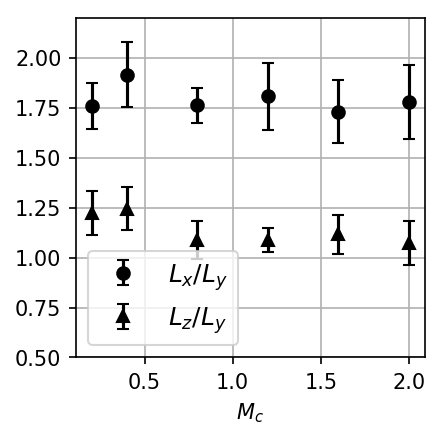

In [12]:

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(lscales['v']['ly_L99'],'$L_y/L_{99}$','o')
plotter(lscales['v']['lx_L99'],'$L_x/L_{99}$','o')
plotter(lscales['v']['lz_L99'],'$L_z/L_{99}$','o')
plt.grid(True)
plt.xlabel('$M_c$')
plt.legend(prop={'size': 12})#,bbox_to_anchor=(0.91,0.32))

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(lscales['v']['ly_dtheta'],r'$L_y/\delta_{\theta}$','o')
plotter(lscales['v']['lx_dtheta'],r'$L_x/\delta_{\theta}$','o')
plotter(lscales['v']['lz_dtheta'],r'$L_z/\delta_{\theta}$','o')
plt.grid(True)
plt.xlabel('$M_c$')
plt.legend(fontsize=10)#,bbox_to_anchor=(0.91,0.32))

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(lscales['v']['lx_ly'],'$L_x/L_y$','ko')
plotter(lscales['v']['lz_ly'],'$L_z/L_y$','k^')
plt.grid(True)
plt.xlabel('$M_c$')
plt.ylim([0.5,2.2])
plt.legend(prop={'size': 12})
